In [1]:
import tensorflow as tf
import src.infovae as infovae
import numpy as np
import matplotlib.pyplot as plt

/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Use a VAE to estimate P(x)

- Does it capture the probability density?
- Are certain digits considered more likely?

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
model_path = '/tmp/infovae/2/infovae.ckpt'
nn = infovae.InfoVAE(6, 8, 4)

In [4]:
x = tf.placeholder(shape=[None, 32, 32, 1], dtype=tf.float32)
x_ = nn(x)

In [6]:
n = 6
def gaussian_d(x, y):
    """
    A conceptual lack of understanding here.
    Do I need a dx to calculate this over?
    Doesnt make sense for a single point!?
    """
    d = tf.norm(x - y, axis=1)
    return tf.exp(-0.5*d)/(tf.sqrt(2*tf.constant(np.pi)))

def pz(z):
    """
    Estimate p(z) using our prior on z.
    """
    z = tf.layers.flatten(z)
    return gaussian_d(z , tf.zeros_like(z))

def px_z(x_, nn):
    # the added noise in the hidden layer.
    return gaussian_d(tf.layers.flatten(nn.y[:,:,:,:1]), 
                      tf.layers.flatten(x_))

def pz_x(nn):
    # the added noise in the final layer.
    return gaussian_d(tf.layers.flatten(nn.h[:,:,:,:n]), 
                      tf.layers.flatten(nn.z))

def p_bayes(x, nn):
    """
    If p(z | x) is far away from p(z) then p(x) is low
    p(x) = p(x | z) p(z) / p(z | x)
    """
    return px_z(x, nn) * pz(nn.z) / pz_x(nn)

px = p_bayes(x_, nn)

In [7]:
saver = tf.train.Saver()

## What likelihood does P(x) assign images in our dataset!?

In [8]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
#     sess.run(tf.global_variables_initializer())
    
    batch_x, _ = mnist.train.next_batch(50)
    prob = sess.run(px, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt


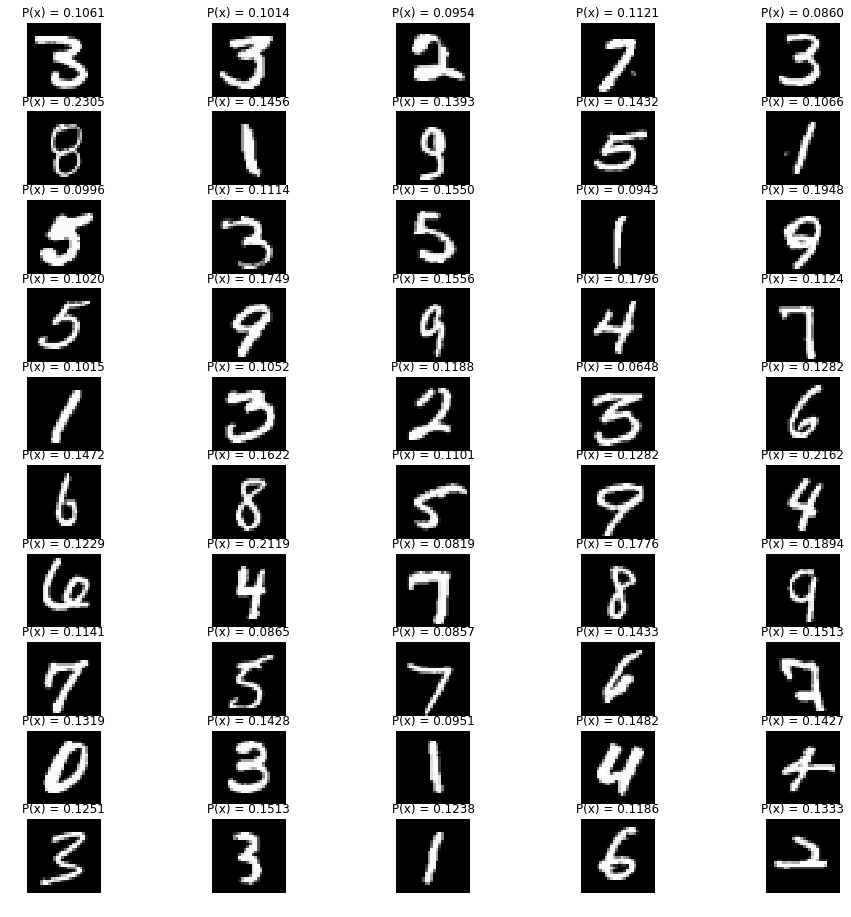

In [9]:
plt.figure(figsize=(16,16))
for i, im in enumerate(batch_x): 
    plt.subplot(10,5,i+1)
    plt.title('P(x) = {:.4f}'.format(prob[i]))
    plt.axis('off')
    plt.imshow(im.reshape((28,28)), interpolation='nearest', cmap='gray')

## What likelihood does P(x) assign noise?

In [10]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    batch_x = np.random.random([50, 28, 28, 1])
    rnd_prob = sess.run(px, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt


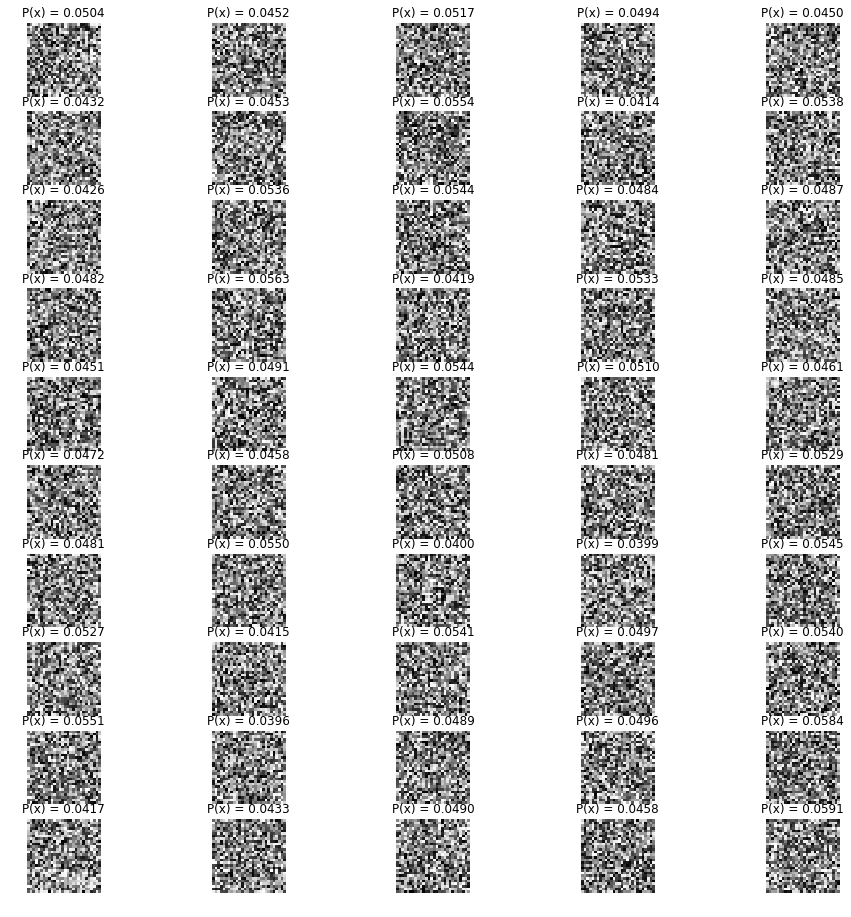

In [11]:
plt.figure(figsize=(16,16))
for i, im in enumerate(batch_x): 
    plt.subplot(10,5,i+1)
    plt.title('P(x) = {:.4f}'.format(rnd_prob[i]))
    plt.axis('off')
    plt.imshow(im.reshape((28,28)), interpolation='nearest', cmap='gray')

In [12]:
with tf.Session() as sess:
    saver.restore(sess, model_path)

    rnd_prob = np.array([sess.run(px, feed_dict={x: infovae.InfoVAE.preprocess(
        np.random.random([50, 28, 28, 1]))})
                for _ in range(100)])
rnd_h = np.histogram(rnd_prob.reshape(-1), bins=50)

INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt


## Which labels are considered more likely?

In [13]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    
    for i in range(1000):
        batch_x, batch_l = mnist.train.next_batch(50)
    
        prob = sess.run(px, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

        if i == 0:
            labels, probs = batch_l, prob
        else:
            labels = np.hstack([labels, batch_l])
            probs = np.hstack([probs, prob])

INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt


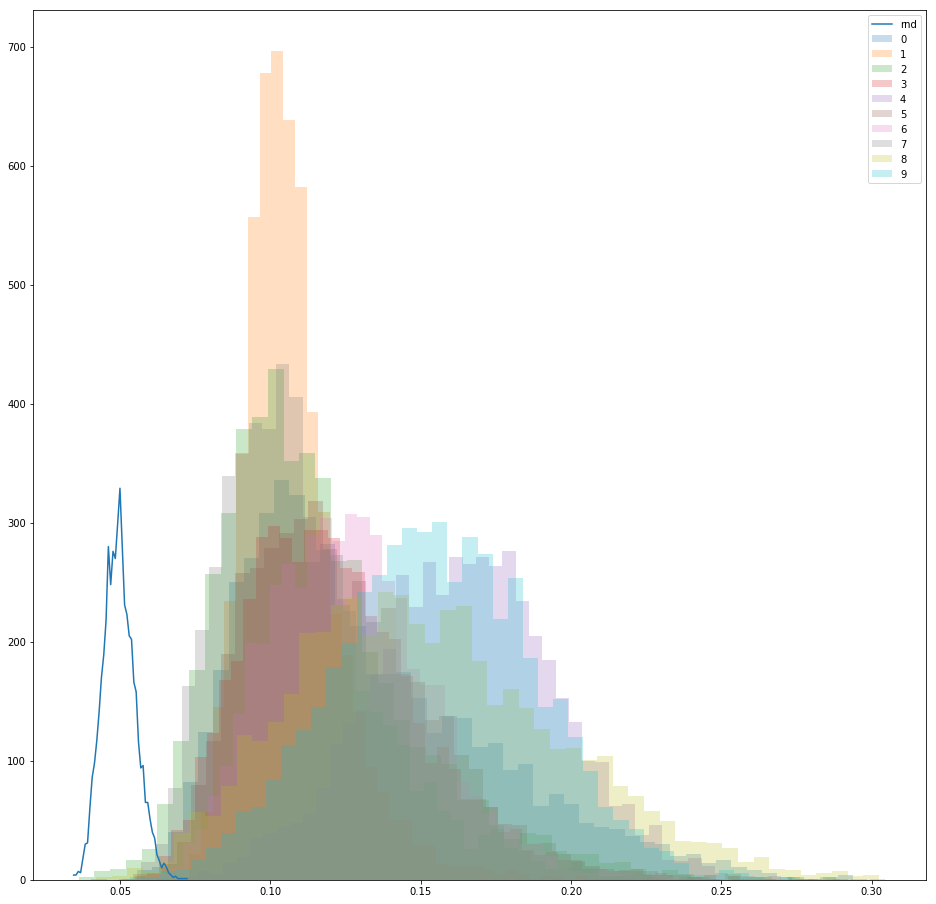

In [14]:
plt.figure(figsize=(16,16))
for i in range(10):
#     plt.subplot(5,2,i+1)
#     plt.title('{}'.format(i))
    _ = plt.hist(probs[labels==i], bins=50, alpha=0.25, label=str(i))
plt.plot(rnd_h[1][1:], rnd_h[0], label='rnd')
plt.legend()

## What does it look like if we maximise P(x)?

Do grad descent on a random image to maximise P(x).

In [15]:
with tf.variable_scope('x_r', reuse=tf.AUTO_REUSE) as scope:
    x_r = tf.get_variable(name='image', shape=[1, 32,32,1], dtype=tf.float32)
y = nn(x_r)
px = p_bayes(y, nn)
loss = -tf.reduce_mean(px)  # maximise p
print(loss)
train_step = tf.train.AdamOptimizer().minimize(loss, var_list=[x_r])

Tensor("Neg:0", shape=(), dtype=float32)


INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt
0.39012885093688965

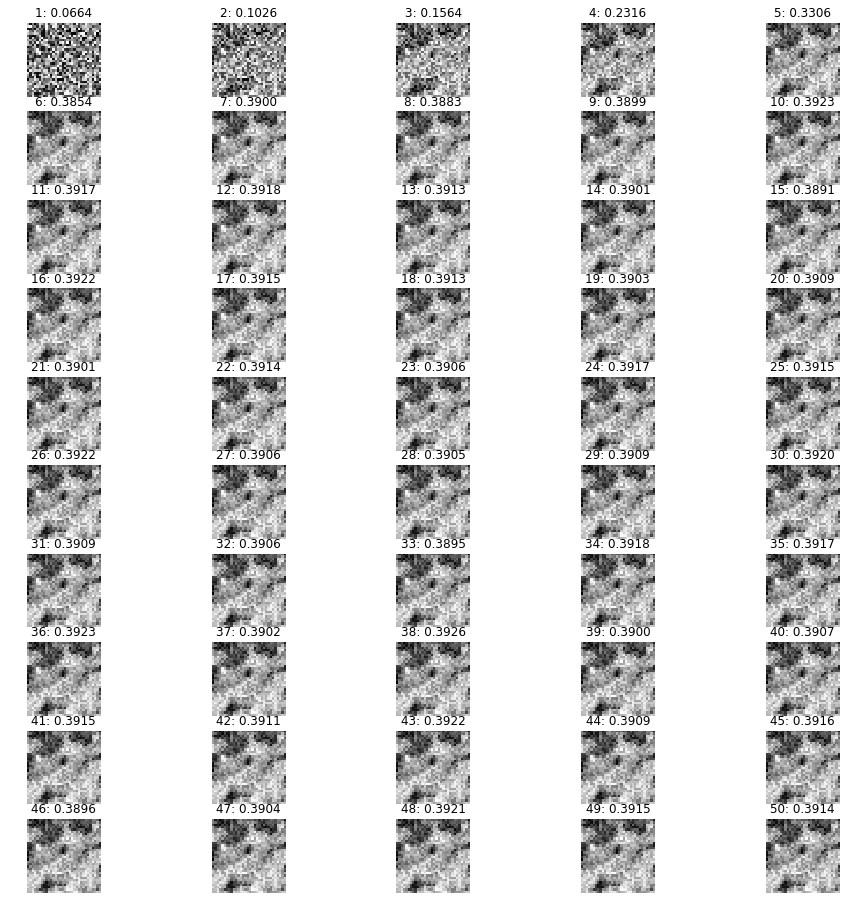

In [16]:
count = 0
plt.figure(figsize=(16,16))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path)
    
    for i in range(1000):
        sess.run(train_step)
        X, P = sess.run([x_r, px])
        print('\r{}'.format(P[0]), end='', flush=True)
        
        if i % 20 == 0:
            count+=1
            plt.subplot(10,5,count)
            plt.title('{}: {:.4f}'.format(count, P[0]))
            plt.imshow(X[0].reshape((32,32)), interpolation='nearest', cmap='gray')
            plt.axis('off')

In [17]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    batch_x = np.random.random([50, 28, 28, 1])
    rnd_recon = sess.run(x_, feed_dict={x: infovae.InfoVAE.preprocess(batch_x)})

INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt


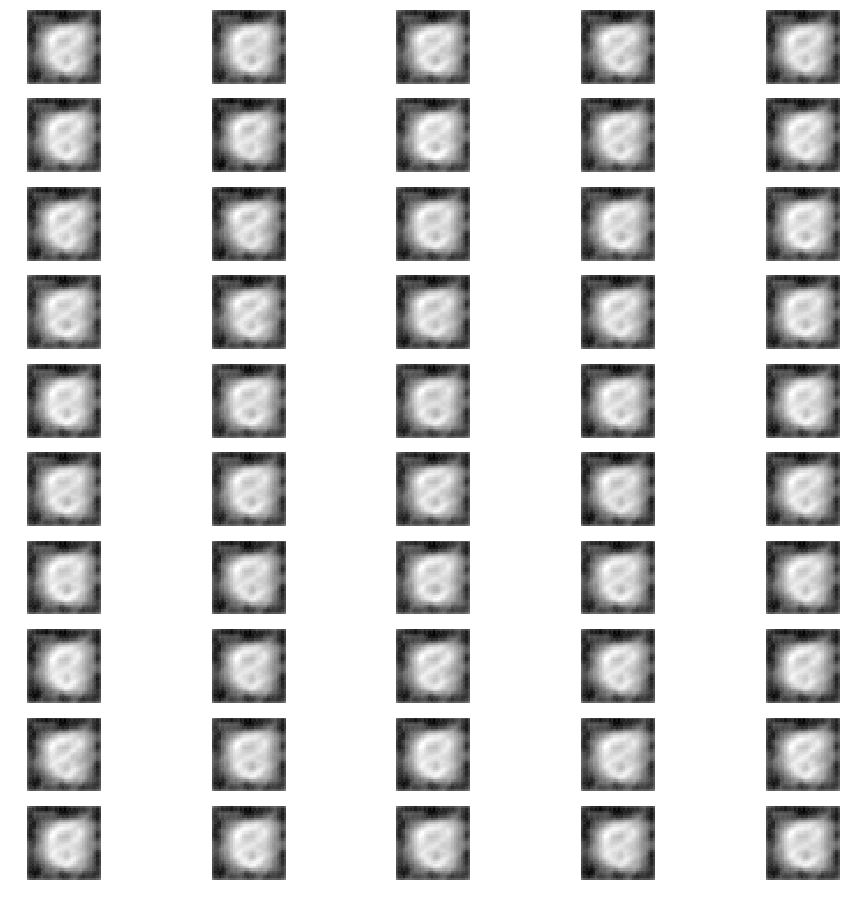

In [18]:
plt.figure(figsize=(16,16))
for i, im in enumerate(rnd_recon): 
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(im.reshape((32,32)), interpolation='nearest', cmap='gray')

In [20]:
# ahh...
with tf.Session() as sess:
    saver.restore(sess, model_path)
    zeros = np.zeros([1, 1, 1, 6], dtype=np.float32)
    zero_recon = sess.run(x_, feed_dict={nn.z: zeros})
plt.imshow(zero_recon[0].reshape((32, 32)), interpolation='nearest', cmap='gray')

INFO:tensorflow:Restoring parameters from /tmp/infovae/2/infovae.ckpt


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,32,32,1]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,32,32,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-310bc7607731>", line 1, in <module>
    x = tf.placeholder(shape=[None, 32, 32, 1], dtype=tf.float32)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/act65/anaconda3/envs/mri/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,32,32,1]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[?,32,32,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
